# Simulation of Group Model

## Load Network

In [24]:
from myGroupModel import myGroupModel

filename = 'output/network_data.json'
model = myGroupModel( filename )

## Run Iteration

In [12]:
from collections import defaultdict
from tqdm import tqdm
model.initialize( percentageInfected = .05 )
num_iter = 40
trend = defaultdict(list)
trendByGroup = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
gTypes = ['AgeLevel']
for _ in tqdm(range(num_iter)):
    model.iteration()
    model.record(trend, trendByGroup, gTypes)

100%|██████████| 40/40 [00:02<00:00, 15.07it/s]


Visualize the result:

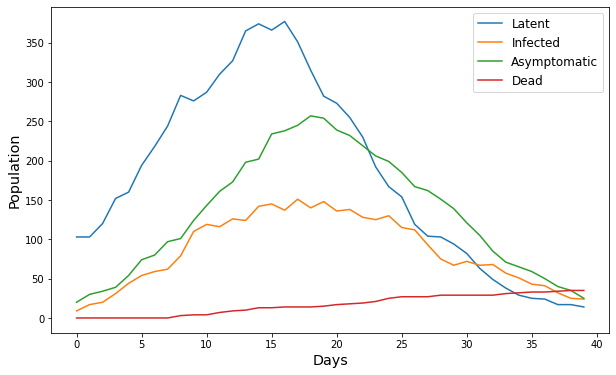

In [13]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

fig, ax = plt.subplots( figsize=(10,6) )
skipped = ['S','RI', 'RA']
for c in model.statusNames: # Drop S, RI and RA
    if c in skipped: continue
    ax.plot(trend[c], label=model.statusNames[c])
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')

with PdfPages('fig_trend.pdf') as pdf:
    pdf.savefig(fig)

Visualing the infectious group by groups

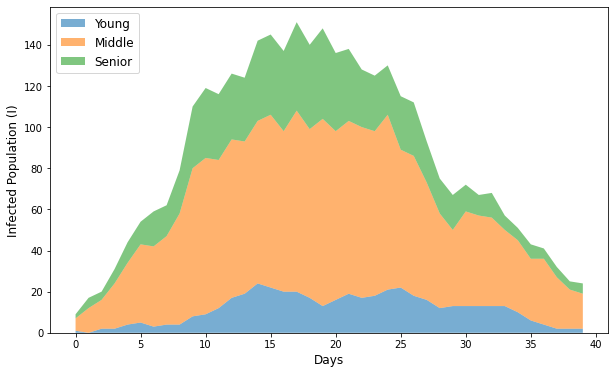

In [14]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

fig, ax = plt.subplots( figsize=(10,6) )
status = 'I'
gType = 'AgeLevel'
gVals = list( model.groups[gType].keys() )
data = dict()
for val in gVals:
    data[val] = trendByGroup[status][gType][val]
days = list(range(num_iter))
ax.stackplot(days, data.values(), labels=data.keys(), alpha=.6)
ax.legend(fontsize='large', loc='upper left')
ax.set_xlabel('Days', fontsize='large')
ax.set_ylabel(f'{model.statusNames[status]} Population ({status})', fontsize='large')

with PdfPages('fig_trend_by_age.pdf') as pdf:
    pdf.savefig(fig)

## Multiple Runs

In [15]:
numRun = 5
initialRate = .05
multiTrend =  [defaultdict(list) for _ in range(numRun)]
for iRun in tqdm(range(numRun)):
    model.initialize( percentageInfected=initialRate )
    numIter = 40
    for _ in range(num_iter):
        model.iteration()
        model.record(multiTrend[iRun])

100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


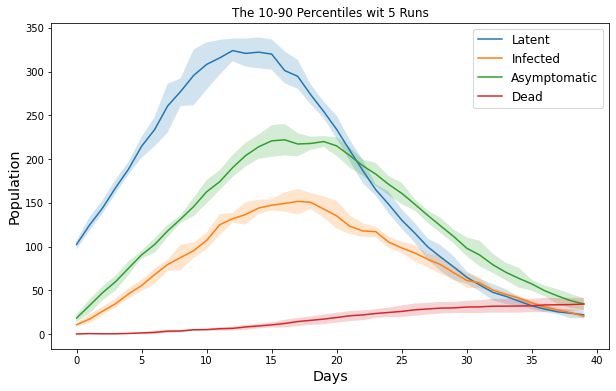

In [16]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
percentile = 10
for j in range(numIter):
    for c in model.statusNames:
        if c in ['RI','RA']: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,6) )
days = list(range(numIter))
for c in model.statusNames:
    if c in ['S','RI','RA']: continue
    ax.plot(days, ave[c], label=model.statusNames[c])
    ax.fill_between(days, lower[c], upper[c], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'The {percentile}-{100-percentile} Percentiles wit {numRun} Runs')

with PdfPages('fig_trend_multi_run.pdf') as pdf:
    pdf.savefig(fig)

## Effects of Importation

In [25]:
from copy import deepcopy
modelOld = model
numVisitorsPerDay = [10, 20, 30, 40]
N = len(numVisitorsPerDay)
newInfectiousRate = .1
contact = 6
quarantine = 0
initialRate = .05
numIter = 40
numRun = 7
finalSizes = [[0] * numRun for _ in range(N)]
for j in tqdm(range(N)):
    num = numVisitorsPerDay[j]
    model = deepcopy(modelOld)
    for iRun in range(numRun):
        model.initialize( percentageInfected=initialRate )
        trend = defaultdict(list)
        for _ in range(num_iter):
            model.addNodes(num, newInfectiousRate, contact, quarantine)
            model.iteration()
            model.record(trend)
        for c in ['L','I','A']:
            finalSizes[j][iRun] += trend[c][-1]
model = modelOld

100%|██████████| 4/4 [01:33<00:00, 23.47s/it]


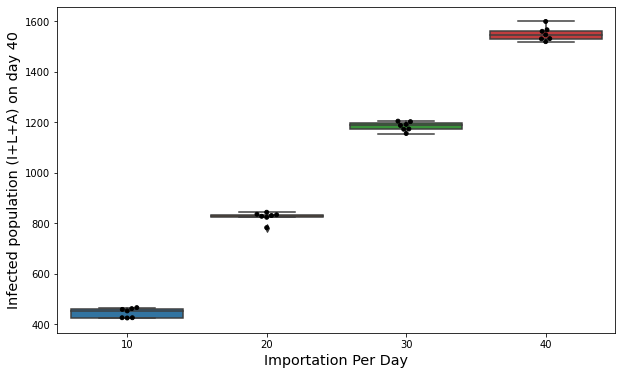

In [26]:
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

fig, ax = plt.subplots( figsize=(10,6) )
sns.boxplot(data=finalSizes, ax=ax)
sns.swarmplot(data=finalSizes, ax=ax, size=4, color='k', linewidth=.9)
plt.xticks(plt.xticks()[0], numVisitorsPerDay)
ax.set_xlabel('Importation Per Day', fontsize='x-large')
ax.set_ylabel(f'Infected population (I+L+A) on day {numIter}', fontsize='x-large')

with PdfPages('fig_importation.pdf') as pdf:
    pdf.savefig(fig)

## Effects of Large Gathering

In [18]:
import random
import itertools
dayOfEvent = [20,21] # Big event days
numIter = 40
numRun = 15
initialRate = .05

numPeople = 400
contactPercentage = .6

nodesList = list(model.graph.nodes.keys())
multiTrend =  [defaultdict(list) for _ in range(numRun)]
for iRun in tqdm(range(numRun)):
    model.initialize( percentageInfected=initialRate )
    for j in range(numIter):
        if j in dayOfEvent:
            participantsList = random.choices(nodesList, k=numPeople)
            edgeAll = list( itertools.combinations(participantsList,2) )
            edgeList = random.choices( edgeAll, k=int(len(edgeAll)*contactPercentage) )
            model.addContacts(edgeList, weight=1)
        model.iteration()
        model.record(multiTrend[iRun])
        if j in dayOfEvent:
            model.addContacts(edgeList, weight=-1)

100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


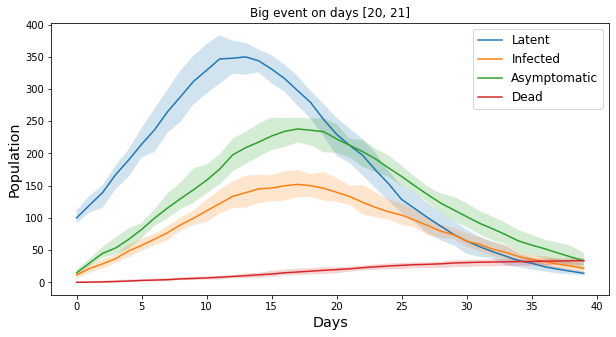

In [21]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

percentile = 5
ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
skipped = ['S','RI','RA']
for j in range(numIter):
    for c in model.statusNames:
        if c in skipped: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,5) )
days = list(range(numIter))
for s, sName in model.statusNames.items():
    if s in skipped: continue
    ax.plot(days, ave[s], label=sName)
    ax.fill_between(days, lower[s], upper[s], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'Big event on days {dayOfEvent}')

with PdfPages('fig_large_gathering.pdf') as pdf:
    pdf.savefig(fig)

## Effects of Family Gathering

In [22]:
import random
import itertools
start = 20 # start day of family gathering
end = 25 # end day of family gathering
numIter = 50
numRun = 5
initialRate = .05
numFamily = 60
numPeopleEach = 20
nodeList = list(model.graph.nodes.keys())

model.params['beta'] = .005

draw = random.choices( nodeList, k = numFamily * numPeopleEach )
count = 0
edgeList = []
for i in range(numFamily):
    members = draw[count:count+numPeopleEach]
    edgeList += list( itertools.combinations( members, 2) )
    count += numPeopleEach

multiTrend =  [defaultdict(list) for _ in range(numRun)]
for iRun in tqdm(range(numRun)):
    model.initialize( percentageInfected=initialRate )
    for j in range(numIter):
        if j == start:
            model.addContacts(edgeList, weight=1)
        model.iteration()
        model.record(multiTrend[iRun])
        if j == end:
            model.addContacts(edgeList, weight=-1)

100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


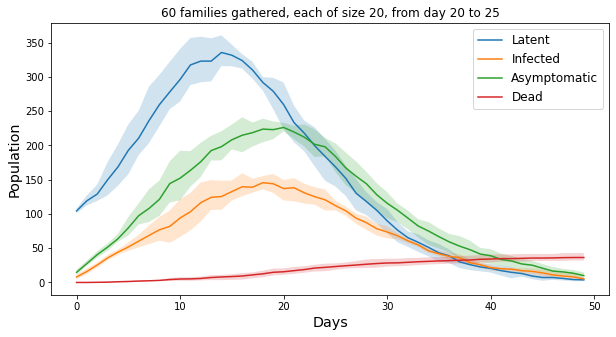

In [23]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

percentile = 10
ave, upper, lower = (defaultdict(lambda: [0]*numIter) for _ in range(3))
skipped = ['S','RI','RA']
for j in range(numIter):
    for c in model.statusNames:
        if c in skipped: continue
        data = [multiTrend[i][c][j] for i in range(numRun)]
        ave[c][j] = np.average(data)
        upper[c][j] = np.percentile(data,percentile)
        lower[c][j] = np.percentile(data,100-percentile)
fig, ax = plt.subplots( figsize=(10,5) )
days = list(range(numIter))
for s, sName in model.statusNames.items():
    if s in skipped: continue
    ax.plot(days, ave[s], label=sName)
    ax.fill_between(days, lower[s], upper[s], alpha=.2)
ax.legend( fontsize='large' )
ax.set_xlabel('Days', fontsize='x-large')
ax.set_ylabel('Population', fontsize='x-large')
ax.set_title(f'{numFamily} families gathered, each of size {numPeopleEach}, from day {start} to {end}')

with PdfPages('fig_family_gathering.pdf') as pdf:
    pdf.savefig(fig)